In [1]:
import numpy as np
from numpy import pi, cos, arccos, sin
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Creating a data frame containing all relevent 
SUN_PATH = pd.DataFrame(np.array([[80, 172, 264, 355], [0, pi/2, pi, -pi/2], [0, np.radians(23.5), 0, np.radians(-23.5)]]).transpose(), columns=['Day of year', 'Ra', 'Dec'])

SUN_PATH

,Day of year,Ra,Dec
0,80.0,0.000000,0.000000
1,172.0,1.570796,0.410152
2,264.0,3.141593,0.000000
3,355.0,-1.570796,-0.410152


In [3]:
# creating a Data Frame for the stars of interest.
df = pd.read_csv("Ariel_MCS_TPCs_01May2023.csv")

starRA = np.radians(df['Star RA'])
starRA = starRA.apply(lambda x: x-2*pi if x>pi else x) # ensures that RA values are between -pi and pi.
starDEC = np.radians(df['Star Dec'])

Equation for angular distance between two points on the celestial sphere is given by:

$$ \theta =  cos^{-1}[sin(\delta_1)sin(\delta_2) + cos(\delta_1)cos(\delta_2)cos(\alpha_2 - \alpha_1)] $$

In [4]:
MIN_ANGLE_TOWARDS_SUN = 70 # in degrees
MIN_ANGLE_AWAY_SUN = 60 # in degrees
NUM_LON_PTS = 360 # number of longitudinal points for background and sinusoid (more points => smoother look)
NUM_LAT_PTS = NUM_LON_PTS//2 # number of latiitudinal points for background (more points => smoother look)


def dist_angle(dec1:float, ra1:float, dec2:float, ra2:float):
    """Returns the distance (in radians) between two points on the celestial sphere.

    Args:
        dec1 (float): Declination of first point (in radians).
        ra1 (float): Right ascention of first point (in radians).
        dec2 (float): Declination of second point (in radians).
        ra2 (float): Right ascention of second point (in radians).

    Returns:
        float: Distance between two given points on the celestial sphere, in radians.
    """
    return arccos( sin(dec1)*sin(dec2) + cos(dec1)*cos(dec2)*cos(ra2-ra1) ) 

ra = np.linspace(-pi, pi, NUM_LON_PTS)
dec = np.linspace(-pi/2, pi/2, NUM_LAT_PTS)
ecliptic = SUN_PATH['Dec'][1]*np.sin(ra)

# preparing data for the pcolormesh to be plotted
Lon, Lat = np.meshgrid(ra, dec)

rho = np.zeros(np.shape(Lon)) # array that will contain all the values for the pcolormesh (higher value = more visible throughout year)
for n in range(len(ra)):
    for i, row in enumerate(dec):
        for j, col in enumerate(ra):
            if dist_angle(row,col, ecliptic[n],ra[n]) > np.radians(MIN_ANGLE_TOWARDS_SUN) and dist_angle(row, col, ecliptic[n]+pi, ra[n]) > np.radians(MIN_ANGLE_AWAY_SUN):
                rho[i][j] += 1
rho /= NUM_LON_PTS # normalizes values such that they are all between 0 and 1. 

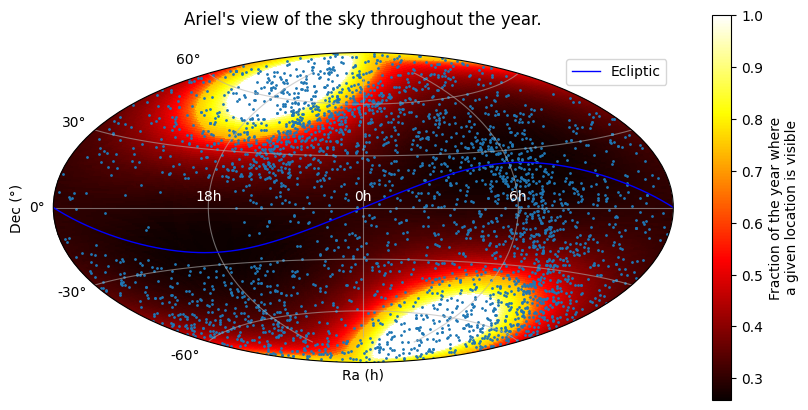

In [7]:
# Preparing the plot
plt.figure(figsize=(10,5))
plt.subplot(projection = 'aitoff')
plt.grid(True, alpha=.6)

# plotting the pcolormesh and its color bar
plt.pcolormesh(Lon, Lat, rho, cmap='hot')
plt.colorbar(label="Fraction of the year where\na given location is visible")

# plotting ecliptic path and stars of interest
# plt.scatter(SUN_PATH['Ra'], SUN_PATH['Dec'], color='green', marker='o', s=15) # plots the position of the sun for key dates.
plt.plot(ra, ecliptic, label='Ecliptic', color='blue', linewidth=1) # plots ecliptic
plt.scatter(starRA, starDEC, s=1, marker='o') # plots the stars of interest

plt.xticks([-pi/2, 0, pi/2], ['18h', '0h', '6h'], color='white')
plt.yticks([-pi/3, -pi/6, 0, pi/6, pi/3])

# adding title and labels
plt.title(f"Ariel's view of the sky throughout the year.", pad=20)
plt.xlabel('Ra (h)')
plt.ylabel('Dec (\u00B0)')
plt.legend(loc='best')

# saving figure to the "Visibility Plots" folder
plt.savefig(f"Visibility Plots/VisibilityPlot.png", bbox_inches='tight', dpi=300)

plt.show()